## Regularized Regression Project

Build a linear regression model that predicts the `price` column in the dataset on San Francisco Apartment rentals. Make sure to go through all the the relevant steps of the modelling workflow.

1. Use the model you built for the prior project as the basis for comparison
2. Engineer (or un-engineer previously) engineered Features as needed
3. Fit a Lasso, Ridge, and Elastic Net Regression using the features in your original model.
4. Once you are ready, fit your final model and report final model performance estimate by scoring on the test data. Report both test R-squared and MAE.
5. What happens to your error if you only model apartments <= 6000 in price... should we do this?

Advice:

1. Remember, regularization doesn't always help!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

rentals_df = pd.read_csv("../Data/sf_clean.csv")

rentals_df.head()

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
0,6800,1600.0,2.0,2.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
1,3500,550.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,7.0
2,5100,1300.0,2.0,1.0,(a) in-unit,(a) both,(c) multi,(d) no parking,7.0
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
4,3100,561.0,1.0,1.0,(c) no laundry,(a) both,(c) multi,(d) no parking,7.0


### Data Dictionary

1. Price: The price of the rental and our target variable
2. sqft: The area in square feet of the rental
3. beds: The number of bedrooms in the rental
4. bath: The number of bathrooms in the rental
5. laundry: Does the rental have a laundry machine inside the house, a shared laundry machine, or no laundry on site?
6. pets: Does the rental allow pets? Cats only, dogs only or both cats and dogs?
7. Housing type: Is the rental in a multi-unit building, a building with two units, or a stand alone house? 
8. Parking: Does the apartment off a parking space? No, protected in a garage, off-street in a parking lot, or valet service?
9. Hood district: Which part of San Francisco is the apartment located?

![image info](SFAR_map.png)

In [2]:
rentals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          989 non-null    int64  
 1   sqft           989 non-null    float64
 2   beds           989 non-null    float64
 3   bath           989 non-null    float64
 4   laundry        989 non-null    object 
 5   pets           989 non-null    object 
 6   housing_type   989 non-null    object 
 7   parking        989 non-null    object 
 8   hood_district  989 non-null    float64
dtypes: float64(4), int64(1), object(4)
memory usage: 69.7+ KB


## EDA

1. Based on the range of prices below, we may need to subset our data based on some value to predict more "realistic" apartments. Possibly subset based on square-footage.

2. The 'hood_district' feature was read in as an integer but is really a categorical feature. Let's fix that.


In [3]:
rentals_df["hood_district"] = rentals_df["hood_district"].astype("object") 

In [4]:
rentals_df.describe()

,price,sqft,beds,bath
count,989.000000,989.000000,989.000000,989.000000
mean,3595.035389,976.765420,1.679474,1.390293
std,1546.222670,474.629798,1.076710,0.562714
min,750.000000,150.000000,0.000000,1.000000
25%,2650.000000,650.000000,1.000000,1.000000
50%,3300.000000,900.000000,2.000000,1.000000
75%,4242.000000,1200.000000,2.000000,2.000000
max,19000.000000,3500.000000,6.000000,4.000000


There are some very rare, expensive apartments that cost over 10k.

<Axes: xlabel='price', ylabel='Count'>

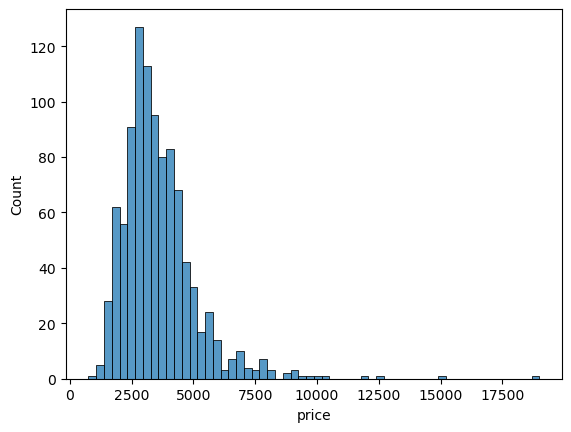

In [5]:
sns.histplot(rentals_df, x="price")

Most of our numeric features are positively correlated with each other, could cause problems.

It's good to see that we have some strong correlations with our target here though.

In [6]:
# sns.heatmap(
#     rentals_df.corr(numeric_only=True), 
#     vmin=-1, 
#     vmax=1, 
#     cmap="coolwarm",
#     annot=True
# );

Based on the pairplot below, we may be able to slice off the most expensive aparments by subsetting to only aparments <2500 sqft. 

In [7]:
# sns.pairplot(rentals_df, corner=True)

Moving on to our categorical features, we have some rare categories that may need to be binned together.

We should consider:

1. Pets: Bin 'dogs', and 'both' into a 'dogs' 'allows_dogs' category.
2. Housing_type: Group 'multi' and 'double' together
3. Parking: Group 'protected', 'off-street', and 'valet' together
4. We should bin some of our lower count neighbhoords with neighboring ones. Let's look at average pricing for each and see which are related based on price.

In [8]:
# # Let's check the frequency of our categorical features

# def value_counter(dataframe):
#     value_series = pd.DataFrame()
#     for col in dataframe.select_dtypes(["object"]).columns:
#         print(dataframe[col].value_counts())
        
        
# value_counter(rentals_df)

In [9]:
# def cat_plotter(data, target):
#     for col in data.select_dtypes(["object"]).columns:
#         sns.barplot(data=data, x=col, y=target)
#         plt.xticks(rotation=45)
#         plt.show()
        
# cat_plotter(rentals_df, "price")

# Feature Engineering

1. Group Categories together
2. Trying a Squared Term for Bedrooms, sqft, and bath

In [10]:
laundry_map = {
    "(a) in-unit": "in_unit",
    "(b) on-site": "not_in_unit",
    "(c) no laundry": "not_in_unit",
}

pet_map = {
    "(a) both": "allows_dogs",
    "(b) dogs": "allows_dogs",
    "(c) cats": "no_dogs",
    "(d) no pets": "no_dogs"
}


housing_type_map = {
    "(a) single": "single",
    "(b) double": "multi",
    "(c) multi": "multi",
}

district_map = {
    1.0: "west",
    2.0: "southwest",
    3.0: "southwest",
    4.0: "central",
    5.0: "central",
    6.0: "central",
    7.0: "marina",
    8.0: "north beach",
    9.0: "FiDi/SOMA",
    10.0: "southwest"
    
}

In [11]:
eng_df = rentals_df.assign(
#     hood_district = rentals_df["hood_district"].map(district_map),
#     housing_type = rentals_df["housing_type"].map(housing_type_map),
#     pets = rentals_df["pets"].map(pet_map),
#     laundry = rentals_df["laundry"].map(laundry_map),
    sqft2 = rentals_df["sqft"] ** 2,
    sqft3 = rentals_df["sqft"] ** 3,
    beds2 = rentals_df["beds"] ** 2,
    beds3 = rentals_df["beds"] ** 3,
    bath2 = rentals_df["bath"] ** 2,
    bath3 = rentals_df["bath"] ** 3,
    beds_bath_ratio = rentals_df["beds"] / rentals_df["bath"]
)

eng_df = pd.get_dummies(eng_df, drop_first=True)

/var/folders/f8/075hbnj13wb0f9yzh9k4nyz00000gn/T/ipykernel_69111/3577814233.py:15: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  eng_df = pd.get_dummies(eng_df, drop_first=True)


In [12]:
eng_df.head()

,price,sqft,beds,bath,sqft2,sqft3,beds2,beds3,bath2,bath3,...,parking_(d) no parking,hood_district_2.0,hood_district_3.0,hood_district_4.0,hood_district_5.0,hood_district_6.0,hood_district_7.0,hood_district_8.0,hood_district_9.0,hood_district_10.0
0,6800,1600.0,2.0,2.0,2560000.0,4.096000e+09,4.0,8.0,4.00,8.000,...,0,0,0,0,0,0,1,0,0,0
1,3500,550.0,1.0,1.0,302500.0,1.663750e+08,1.0,1.0,1.00,1.000,...,0,0,0,0,0,0,1,0,0,0
2,5100,1300.0,2.0,1.0,1690000.0,2.197000e+09,4.0,8.0,1.00,1.000,...,1,0,0,0,0,0,1,0,0,0
3,9000,3500.0,3.0,2.5,12250000.0,4.287500e+10,9.0,27.0,6.25,15.625,...,0,0,0,0,0,0,1,0,0,0
4,3100,561.0,1.0,1.0,314721.0,1.765585e+08,1.0,1.0,1.00,1.000,...,1,0,0,0,0,0,1,0,0,0


In [13]:
from sklearn.model_selection import train_test_split

target = "price"
drop_cols = [
#     "pets_no_dogs",
#     "housing_type_single"
]

X = sm.add_constant(eng_df.drop([target] + drop_cols, axis=1))

# Log transform slightly improves normality
y = np.log(eng_df[target])
# y = eng_df[target]

# Test Split
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=2023)

# Scaling Data

In [14]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
X_tr = std.fit_transform(X.values)
X_te = std.transform(X_test.values)

In [15]:
from sklearn.linear_model import RidgeCV

n_alphas = 100
alphas = 10 ** np.linspace(-3, 3, n_alphas)

ridge_model = RidgeCV(alphas=alphas, cv=5)

ridge_model.fit(X_tr, y)
print(f"Cross Val R2: {ridge_model.score(X_tr, y)}")
print(f"Cross Val MAE: {mae(np.exp(y), np.exp(ridge_model.predict(X_tr)))}")
print(f"Alpha: {ridge_model.alpha_}")

Cross Val R2: 0.838593191451734
Cross Val MAE: 449.78809785101487
Alpha: 0.13219411484660287


In [16]:
list(zip(X.columns, ridge_model.coef_))

[('const', 0.0),
 ('sqft', 0.42771896617523025),
 ('beds', 0.08215303569593947),
 ('bath', 0.09371487268132178),
 ('sqft2', -0.33112295982958595),
 ('sqft3', 0.11335893359958782),
 ('beds2', -0.1654342782544933),
 ('beds3', 0.0918199399130907),
 ('bath2', -0.06537874836099966),
 ('bath3', 0.058336837379734746),
 ('beds_bath_ratio', 0.06102729477529018),
 ('laundry_(b) on-site', -0.038419760376628705),
 ('laundry_(c) no laundry', -0.02976713155248345),
 ('pets_(b) dogs', 0.006837484179375996),
 ('pets_(c) cats', -0.0029892295960895613),
 ('pets_(d) no pets', -0.004706036634352949),
 ('housing_type_(b) double', -0.010757739645693218),
 ('housing_type_(c) multi', -0.0029333782859908633),
 ('parking_(b) protected', -0.08372878097175306),
 ('parking_(c) off-street', -0.029978914464803084),
 ('parking_(d) no parking', -0.11016786659078776),
 ('hood_district_2.0', -0.00740287445225464),
 ('hood_district_3.0', -0.010093156137140784),
 ('hood_district_4.0', 0.002065237315987054),
 ('hood_distri

# Lasso

In [17]:
from sklearn.linear_model import LassoCV

n_alphas = 200
alphas = 10 ** np.linspace(-2, 3, n_alphas)

lasso_model = LassoCV(alphas=alphas, cv=5)

lasso_model.fit(X_tr, y)

print(f"Cross Val R2: {lasso_model.score(X_tr, y)}")
print(f"Cross Val MAE: {mae(np.exp(y), np.exp(lasso_model.predict(X_tr)))}")
print(f"Alpha: {lasso_model.alpha_}")

Cross Val R2: 0.8129780229340178
Cross Val MAE: 490.47394723593777
Alpha: 0.01


In [18]:
list(zip(X.columns, lasso_model.coef_))

[('const', 0.0),
 ('sqft', 0.20409896612931414),
 ('beds', 0.0),
 ('bath', 0.08265620267301405),
 ('sqft2', -0.0),
 ('sqft3', -0.006974225557041329),
 ('beds2', -0.0),
 ('beds3', -0.0),
 ('bath2', 0.0),
 ('bath3', 0.0),
 ('beds_bath_ratio', 0.07600636348963834),
 ('laundry_(b) on-site', -0.0405011531679651),
 ('laundry_(c) no laundry', -0.029539680091455068),
 ('pets_(b) dogs', 0.0006873438790042108),
 ('pets_(c) cats', -0.0),
 ('pets_(d) no pets', -0.0),
 ('housing_type_(b) double', -0.005332280277401441),
 ('housing_type_(c) multi', 0.004875469501529802),
 ('parking_(b) protected', -0.0),
 ('parking_(c) off-street', 0.0),
 ('parking_(d) no parking', -0.03361242231604274),
 ('hood_district_2.0', -0.012463294976318992),
 ('hood_district_3.0', -0.007325466046783179),
 ('hood_district_4.0', -0.0),
 ('hood_district_5.0', 0.004126237093391836),
 ('hood_district_6.0', 0.000821209218527959),
 ('hood_district_7.0', 0.019715820333462107),
 ('hood_district_8.0', -0.002513009123186501),
 ('hood_

In [19]:
# print(mae(np.exp(y_test), np.exp(lasso_model.predict(X_te))))
# print(f"Test R2: {r2(y_test, lasso_model.predict(X_te))}")

## ENET

In [20]:
from sklearn.linear_model import ElasticNetCV

alphas = 10 ** np.linspace(-2, 3, 200)
l1_ratios = np.linspace(.01, 1, 100)

enet_model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5)

enet_model.fit(X_tr, y)

print(f"Cross Val R2: {enet_model.score(X_tr, y)}")
print(f"Cross Val MAE: {mae(np.exp(y), np.exp(enet_model.predict(X_tr)))}")
print(f"Alpha: {enet_model.alpha_}")
print(f"L1_Ratio: {enet_model.l1_ratio_}")

Cross Val R2: 0.8346175733621186
Cross Val MAE: 457.36513834175764
Alpha: 0.01
L1_Ratio: 0.01


# Final Model Test

In [21]:
print(f"Test MAE: {mae(np.exp(y_test), np.exp(ridge_model.predict(X_te)))}")
print(f"Test R2: {r2(y_test, ridge_model.predict(X_te))}")

Test MAE: 422.24068172028757
Test R2: 0.7988883883318496
